
### The transient Universe

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [53]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from IPython.display import display, Math

In [54]:
data = np.load("../solutions/transient.npy")
time = data[:, 0]
flux = data[:, 1]
flux_err = data[:, 2]

Text(0, 0.5, 'Flux')

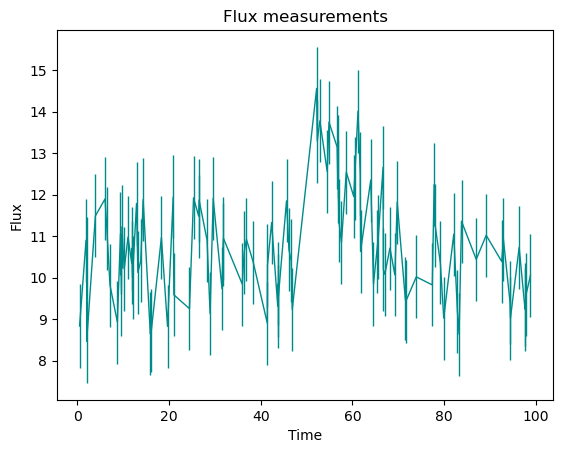

In [55]:
#Plot data

plt.figure()
plt.errorbar(time, flux, flux_err, c="darkcyan", lw=1)
plt.title("Flux measurements")
plt.xlabel("Time")
plt.ylabel("Flux")

In defining the dataset likelihood I assume a normal distribution for the likelihoods of the individual data

In [57]:
#Define model, priors, likelihood and posterior

def BurstModel(t, b, A, t_0, alpha):
    y = np.zeros(len(t))
    
    for i in range(0, len(t)):
        if t[i] < t_0:
            y[i] = b
        
        else:
            y[i] = b + A * np.exp(-alpha * (i - t_0))
        
    return y
        

def LogLikelihood(flux, t, flux_err, b, A, t_0, alpha):
    burst = BurstModel(t, b, A, t_0, alpha)
    
    return np.sum(-(flux - burst)**2 / (2 * flux_err**2) - np.log(np.sqrt(2 * np.pi * flux_err**2)))


#The prior for alpha is a log-uniform

def Prior(b, A, t_0, alpha):
    prior_b = 1 / 50
    prior_A = 1 / 50
    prior_t0 = 1 / 100
    prior_alpha = (1 / 10) / alpha

    if b < 0 or b > 50:
        prior_b = 0

    if A < 0 or A > 50:
        prior_A = 0

    if t_0 < 0 or t_0 > 100:
        prior_t0 = 0

    if alpha < np.exp(-5) or alpha > np.exp(5):
        prior_alpha = 0
    
    return prior_b * prior_A * prior_t0 * prior_alpha
    

def LogPosterior(params, flux, t, flux_err):
    b, A, t_0, alpha = params

    prior = Prior(b, A, t_0, alpha)
    L = LogLikelihood(flux, t, flux_err, b, A, t_0, alpha)

    if prior == 0:
        return -np.inf

    else:
        return np.log(prior) + L

In [58]:
n_walkers = 10
n_dim = 4
n_steps = 18000

#Start at a point picked by eye plus a random component
start_point = np.random.random((n_walkers, n_dim)) + [min(flux) + 3, max(flux) - min(flux) + 1, time[np.where(flux == max(flux))[0][0]] + 1, 0.13]

sampler = emcee.EnsembleSampler(n_walkers, n_dim, LogPosterior, args=[flux, time, flux_err], threads=-1)
sampler.run_mcmc(start_point, n_steps, progress=True)

  0%|                                                                                        | 0/18000 [00:00<?, ?it/s]C:\Users\Utente\AppData\Local\Temp\ipykernel_10148\3597544744.py:11: RuntimeWarning: overflow encountered in exp
  y[i] = b + A * np.exp(-alpha * (i - t_0))
C:\Users\Utente\AppData\Local\Temp\ipykernel_10148\3597544744.py:19: RuntimeWarning: overflow encountered in square
  return np.sum(-(flux - burst)**2 / (2 * flux_err**2) - np.log(np.sqrt(2 * np.pi * flux_err**2)))
C:\Users\Utente\AppData\Local\Temp\ipykernel_10148\3597544744.py:11: RuntimeWarning: overflow encountered in scalar multiply
  y[i] = b + A * np.exp(-alpha * (i - t_0))
100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [00:25<00:00, 716.02it/s]


State([[10.30213407  4.30590609 49.417361    0.0770531 ]
 [10.36056968  5.19741498 48.30365675  0.10645767]
 [10.17341238  6.66674539 47.52304747  0.1100769 ]
 [ 9.98538707  4.1258637  49.981442    0.06478787]
 [10.43835294  6.56833097 46.88372594  0.11683188]
 [10.32446883  4.62781973 50.42710327  0.13028391]
 [10.38001168  6.47217694 47.11275254  0.11580498]
 [10.07855045  7.07268454 48.13579781  0.12122835]
 [10.27905931  4.01605426 50.48463891  0.06254496]
 [10.36936806  4.7907402  50.96089732  0.12152321]], log_prob=[-153.12367598 -153.43604376 -154.37990531 -155.54460124 -154.11942948
 -154.90046406 -153.78318518 -157.24307337 -155.7601232  -154.38012734], blobs=None, random_state=('MT19937', array([4273836791, 1023473234,  125854626, 3421330959, 4153628054,
       1077035824, 2868801855, 2206526816,  368545664,  777392376,
        364816802, 2772229955, 2170799235, 2972308377, 2259040537,
       4169115355,  532299372, 2395856590,    5645233, 3646930908,
       2976982685, 30242

In [59]:
#Burn in and thinning

burn_in = 2000
tau = sampler.get_autocorr_time()
thin = int(max(tau))
trace = sampler.get_chain(discard=burn_in, thin=thin, flat=True)

acc_fraction = sampler.acceptance_fraction
print("Acceptance for each walker = " + str(acc_fraction))

Acceptance for each walker = [0.52744444 0.53861111 0.53077778 0.53155556 0.53155556 0.53833333
 0.54244444 0.51838889 0.53444444 0.52466667]


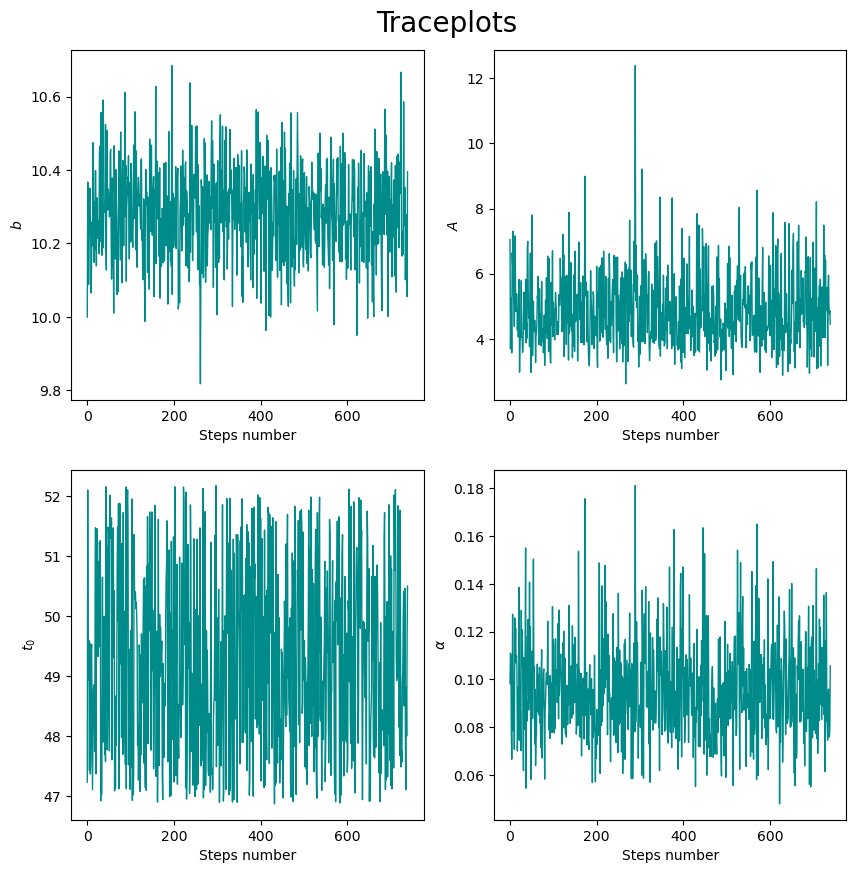

In [60]:
#Get the trace for every parameter

b_trace = trace[:, 0]
A_trace = trace[:, 1]
t0_trace = trace[:, 2]
alpha_trace = trace[:, 3]
x_grid = np.arange(0, len(trace[:,0]))

#Traceplots

fig_trace = plt.figure(figsize=(10, 10))
fig_trace.suptitle("Traceplots", size=20, y=0.92)
params_name = ["b", "A", "t_0", "\\alpha"]

for i in range(1, n_dim + 1):
    ax_trace = fig_trace.add_subplot(2, 2, i)
    ax_trace.plot(x_grid, trace[:, i - 1], c="darkcyan", lw=1)
    ax_trace.set_xlabel("Steps number", size=10)
    ax_trace.set_ylabel("$" + params_name[i - 1] + "$", size=10)

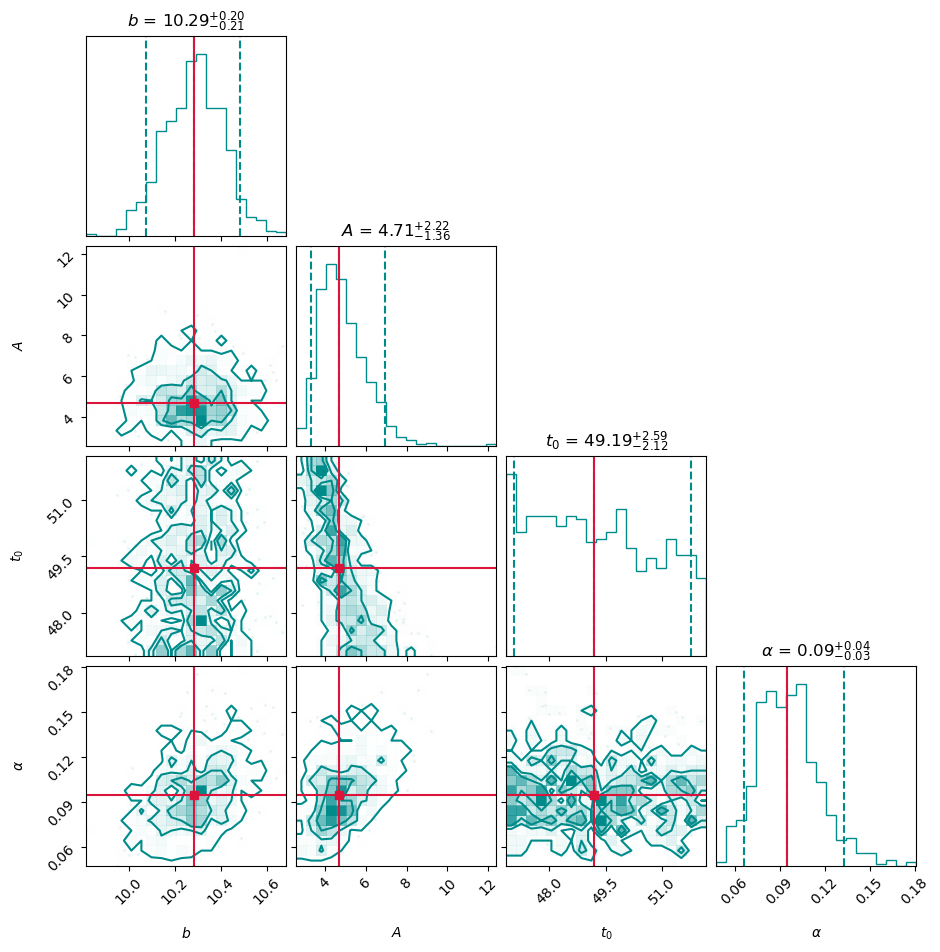

In [61]:
#Cornerplot

medians = np.array([np.median(trace[:, i]) for i in range(0, n_dim)])
regions_90 = np.array([corner.quantile(trace[:, i], [0.05, 0.95]) for i in range(0, n_dim)])

fig_corner = corner.corner(trace, labels=[r"$b$", r"$A$", r"$t_0$", r"$\alpha$"], show_titles=True, 
                           quantiles=[0.05, 0.50, 0.95], levels=[0.39, 0.68, 0.95], 
                           truths=medians, 
                           color="darkcyan", truth_color="crimson")

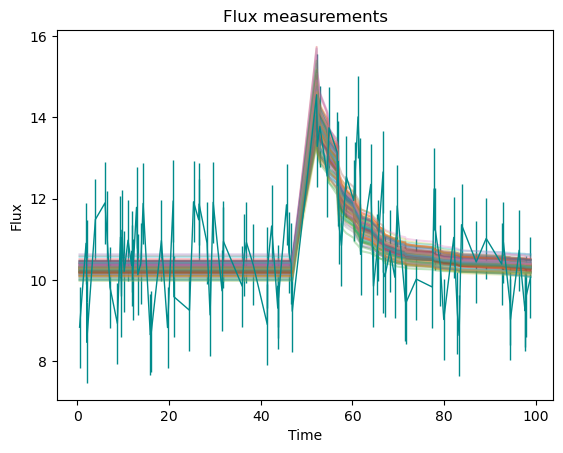

In [62]:
#Posterior spread of solutions

random_samples = trace[np.random.choice(trace.shape[0], replace=False, size=100)]

plt.figure()
plt.errorbar(time, flux, flux_err, c="darkcyan", lw=1)
plt.title("Flux measurements")
plt.xlabel("Time")
plt.ylabel("Flux")

for i in random_samples:
    plt.plot(time, BurstModel(time, i[0], i[1], i[2], i[3]), alpha=0.3)

In [63]:
#Print parameter medians and 90% credible regions

par_names = ["b", "A", "t_0", "\\alpha"]

for i in range(0, n_dim):
    text = par_names[i] + " =" + f"{medians[i]: .2f}" + "^{+" + f"{regions_90[i, 1] - medians[i]: .2f}" + "}_{-" + f"{medians[i] - regions_90[i, 0]: .2f}" + "}"
    display(Math(text))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>